In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../src/')

In [42]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from src.model_evaluation.resampling import *
cancer = load_breast_cancer()

X_train, X_test, z_train, z_test = train_test_split(cancer.data,cancer.target,test_size= 0.3)
Xscaler = StandardScaler().fit(X_train)

X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

In [4]:
from src.modelling.nn import NeuralNetwork
nn = NeuralNetwork(hidden_activation = 'relu',output_activation = 'sigmoid', loss_func = 'cross_entropy',
                   momentum = 0.5,w_init='glorot',batch_size = 32,n_epochs = 100,val_fraction=0.1)
nn.fit(X_train,z_train)

In [7]:
print("Train score: ",nn.score(X_train,z_train))
print("Train score: ",nn.score(X_test,z_test))

Train score:  0.9788732394366197
Train score:  0.965034965034965


In [19]:
cancer.target.shape

(569,)

In [31]:
a = cross_validate(nn,cancer.data,cancer.target,5,Xscaler)

In [28]:
import numpy as np
np.mean(a)

0.9859408135723925

In [32]:
a

{'train_scores': [0.9824175824175824,
  0.9912087912087912,
  0.9868131868131869,
  0.9846153846153847,
  0.9846491228070176],
 'test_scores': [0.9736842105263158,
  0.9649122807017544,
  0.9824561403508771,
  0.9649122807017544,
  0.9734513274336283]}

In [44]:
cross_val_score(nn,cancer.data,cancer.target,5,Xscaler)

(0.9850616926932716, 0.9789007918025152)

In [36]:
from src.modelling.logreg import SGD_logreg
logreg = SGD_logreg()

In [37]:
cross_val_score(logreg,cancer.data,cancer.target,5,Xscaler)

(0.9819857335646809, 0.9631268436578171)

In [38]:
from sklearn.neural_network import MLPClassifier

nn_sk = MLPClassifier(max_iter = 100, hidden_layer_sizes=(50,),
                     activation = 'relu',solver='sgd',
                     learning_rate_init=0.01,batch_size = 32,momentum= 0.5,alpha=0.0001,tol=0)
nn_sk.fit(X_train,z_train)

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=32, hidden_layer_sizes=(50,), learning_rate_init=0.01,
              max_iter=100, momentum=0.5, solver='sgd', tol=0)

In [43]:
cross_val_score(nn_sk,cancer.data,cancer.target,5,Xscaler)

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

(0.9868208983998457, 0.9771774569166277)

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas)
nlrs = 10
lrs = np.logspace(-4, 2, nlrs)

gridsearch = GridSearchCV(estimator=nn_sk, param_grid=dict(alpha=lambdas,learning_rate_init=lrs),n_jobs=-1)
gridsearch.fit(X_train,z_train)

GridSearchCV(estimator=MLPClassifier(batch_size=32, hidden_layer_sizes=(50,),
                                     learning_rate_init=0.01, max_iter=100,
                                     momentum=0.5, solver='sgd', tol=0),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                         'learning_rate_init': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])})

Ok so I guess on wouldn't scale on every kfold in the cross validation, you scale to begin with, only use your training data for parameter tuning(obviously), which means gridsearch, and then test on test data. I.e you do need to scale in advance, because how else. Or I guess you could scale test data with training data, and scale training data during cross validation. What would be the difference? The scores in the cross validation would be kind of biased. It's as if we'd scale the the whole data set, and then split into train and test.

In [78]:
print(gridsearch.cv_results_['param_learning_rate_init'].reshape(10,10))

[[0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823 1.0 4.641588833612772
  21.54434690031882 100.0]
 [0.0001 0.00046415888336127773 0.002154434690031882 0.01
  0.046415888336127774 0.21544346900318823

In [167]:
df_test = pd.DataFrame(gridsearch.cv_results_)
df_test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.3554,0.0050,0.0008,3.9964e-04,0.0001,0.0001,"{'alpha': 0.0001, 'learning_rate_init': 0.0001}",0.9250,0.8000,0.6375,0.6962,0.6709,0.7459,0.1047,64
1,0.3560,0.0097,0.0008,4.0004e-04,0.0001,0.0005,"{'alpha': 0.0001, 'learning_rate_init': 0.0004...",0.9375,0.9625,0.9500,0.9367,0.9494,0.9472,0.0095,42
2,0.3608,0.0104,0.0004,4.8910e-04,0.0001,0.0022,"{'alpha': 0.0001, 'learning_rate_init': 0.0021...",0.9875,0.9625,0.9375,0.9620,0.9620,0.9623,0.0158,34
3,0.3534,0.0076,0.0010,1.0160e-06,0.0001,0.0100,"{'alpha': 0.0001, 'learning_rate_init': 0.01}",1.0000,0.9875,0.9625,0.9620,0.9747,0.9773,0.0147,4
4,0.3506,0.0034,0.0008,3.9971e-04,0.0001,0.0464,"{'alpha': 0.0001, 'learning_rate_init': 0.0464...",1.0000,0.9750,0.9625,0.9620,0.9747,0.9748,0.0138,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0872,0.0155,0.0004,4.8963e-04,100.0000,0.2154,"{'alpha': 100.0, 'learning_rate_init': 0.21544...",0.6250,0.6250,0.6250,0.6329,0.6203,0.6256,0.0041,67
96,0.0426,0.0010,0.0004,4.8980e-04,100.0000,1.0000,"{'alpha': 100.0, 'learning_rate_init': 1.0}",0.0625,0.0375,0.1125,0.1013,0.0633,0.0754,0.0275,100
97,0.2016,0.1304,0.0006,1.1999e-03,100.0000,4.6416,"{'alpha': 100.0, 'learning_rate_init': 4.64158...",0.3750,0.0500,0.3750,0.1013,0.3797,0.2562,0.1483,97
98,0.2766,0.0236,0.0002,3.9997e-04,100.0000,21.5443,"{'alpha': 100.0, 'learning_rate_init': 21.5443...",0.3750,0.3750,0.3750,0.3671,0.3797,0.3744,0.0041,77


KeyError: ('mean_test_score', 'param_learning_rate_init')

In [148]:
score =np.asarray(gridsearch.cv_results_['mean_test_score'], dtype=np.double)
lr = np.asarray(gridsearch.cv_results_['param_learning_rate_init'], dtype=np.double)
lmb = np.asarray(gridsearch.cv_results_['param_alpha'], dtype=np.double)
(np.asarray(lr).astype(np.double)).round(5)

array([1.000000e-04, 4.600000e-04, 2.150000e-03, 1.000000e-02,
       4.642000e-02, 2.154400e-01, 1.000000e+00, 4.641590e+00,
       2.154435e+01, 1.000000e+02, 1.000000e-04, 4.600000e-04,
       2.150000e-03, 1.000000e-02, 4.642000e-02, 2.154400e-01,
       1.000000e+00, 4.641590e+00, 2.154435e+01, 1.000000e+02,
       1.000000e-04, 4.600000e-04, 2.150000e-03, 1.000000e-02,
       4.642000e-02, 2.154400e-01, 1.000000e+00, 4.641590e+00,
       2.154435e+01, 1.000000e+02, 1.000000e-04, 4.600000e-04,
       2.150000e-03, 1.000000e-02, 4.642000e-02, 2.154400e-01,
       1.000000e+00, 4.641590e+00, 2.154435e+01, 1.000000e+02,
       1.000000e-04, 4.600000e-04, 2.150000e-03, 1.000000e-02,
       4.642000e-02, 2.154400e-01, 1.000000e+00, 4.641590e+00,
       2.154435e+01, 1.000000e+02, 1.000000e-04, 4.600000e-04,
       2.150000e-03, 1.000000e-02, 4.642000e-02, 2.154400e-01,
       1.000000e+00, 4.641590e+00, 2.154435e+01, 1.000000e+02,
       1.000000e-04, 4.600000e-04, 2.150000e-03, 1.0000

In [157]:
data = {k[6:]: np.asarray(gridsearch.cv_results_[k],dtype=np.double).round(decimals=5) for k in ('param_alpha', 'param_learning_rate_init')}
data['accuracy'] = np.asarray(gridsearch.cv_results_['mean_test_score'],dtype=np.double).round(decimals=5)

In [158]:
import pandas as pd
#pd.set_option('precision', 4)
df = pd.DataFrame(data)
#df = df.round(decimals=6)
df

,alpha,learning_rate_init,accuracy
0,0.0001,0.0001,0.7459
1,0.0001,0.0005,0.9472
2,0.0001,0.0022,0.9623
3,0.0001,0.0100,0.9773
4,0.0001,0.0464,0.9748
...,...,...,...
95,100.0000,0.2154,0.6256
96,100.0000,1.0000,0.0754
97,100.0000,4.6416,0.2562
98,100.0000,21.5444,0.3744


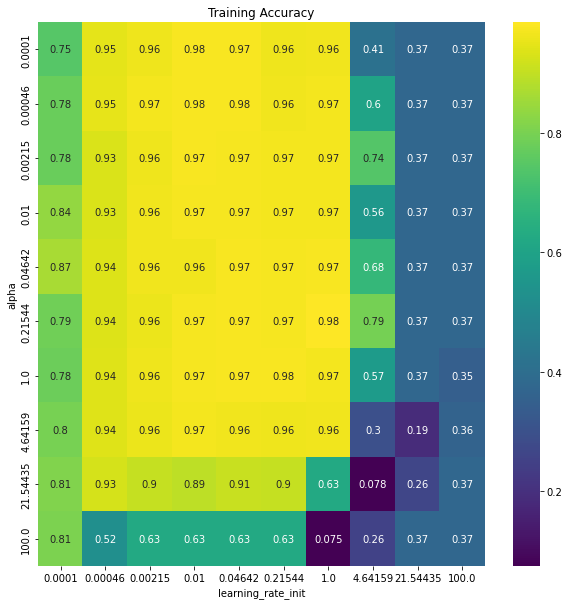

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
df_p = df.pivot("alpha","learning_rate_init","accuracy")
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.heatmap(df_p, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")

#ax.set_ylabel("$\eta$")
#ax.set_xlabel("$\lambda$")
plt.show()

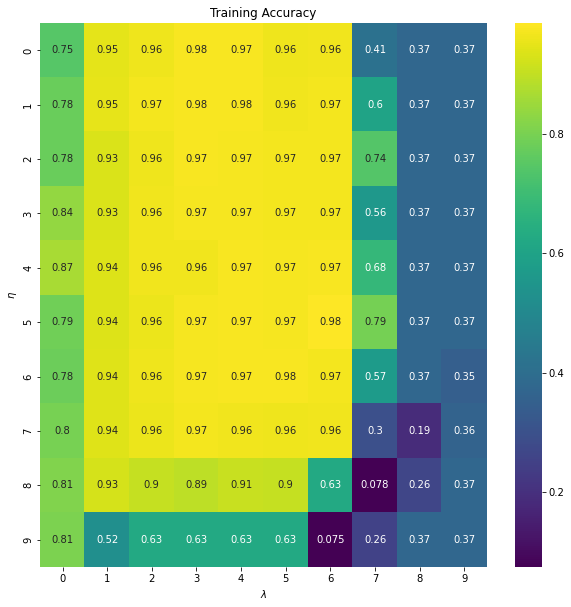

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(gridsearch.cv_results_['mean_test_score'].reshape(10,10), annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [84]:
nn_sk2 = MLPClassifier(max_iter = 100, hidden_layer_sizes=(50,),
                     activation = 'relu',solver='sgd',
                     learning_rate_init=100,batch_size = 32,momentum= 0.5,alpha=0.0001,tol=0)
nn_sk2.fit(X_train,z_train)
nn_sk2.score(X_train,z_train)

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.3743718592964824

Ok I have it now, so lambda and lr are on wrong places. It's like with terrain data, the x is the one that alters values across its rows, meaning every column has same values. y is opposite. If you simply reshape these and print you see that too.

In [85]:
print(gridsearch.cv_results_['param_alpha'].reshape(10,10))

[[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
 [0.00046415888336127773 0.00046415888336127773 0.00046415888336127773
  0.00046415888336127773 0.00046415888336127773 0.00046415888336127773
  0.00046415888336127773 0.00046415888336127773 0.00046415888336127773
  0.00046415888336127773]
 [0.002154434690031882 0.002154434690031882 0.002154434690031882
  0.002154434690031882 0.002154434690031882 0.002154434690031882
  0.002154434690031882 0.002154434690031882 0.002154434690031882
  0.002154434690031882]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.046415888336127774 0.046415888336127774 0.046415888336127774
  0.046415888336127774 0.046415888336127774 0.046415888336127774
  0.046415888336127774 0.046415888336127774 0.046415888336127774
  0.046415888336127774]
 [0.21544346900318823 0.21544346900318823 0.21544346900318823
  0.21544346900318823 0.21544346900318823 0.21544346900318823
  0.21544346900318823 0.21544346900318823 0.21544346900318823
  0.2154434

Here every row has same values, meaning it should be on the y-axis.

In [91]:
print({k: gridsearch.cv_results_[k] for k in ('param_alpha', 'param_learning_rate_init', 'mean_test_score')})

{'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
                   0.0001, 0.0001, 0.0001, 0.00046415888336127773,
                   0.00046415888336127773, 0.00046415888336127773,
                   0.00046415888336127773, 0.00046415888336127773,
                   0.00046415888336127773, 0.00046415888336127773,
                   0.00046415888336127773, 0.00046415888336127773,
                   0.00046415888336127773, 0.002154434690031882,
                   0.002154434690031882, 0.002154434690031882,
                   0.002154434690031882, 0.002154434690031882,
                   0.002154434690031882, 0.002154434690031882,
                   0.002154434690031882, 0.002154434690031882,
                   0.002154434690031882, 0.01, 0.01, 0.01, 0.01, 0.01,
                   0.01, 0.01, 0.01, 0.01, 0.01, 0.046415888336127774,
                   0.046415888336127774, 0.046415888336127774,
                   0.046415888336127774, 0.046415888

In [168]:
dic = {'eple':1,'paere':2}

In [175]:
list(dic.keys())

['eple', 'paere']

In [176]:
param_str =['param_'+s for s in list(dic.keys())]

In [177]:
param_str

['param_eple', 'param_paere']

In [209]:
from src.model_evaluation.param_analysis import *
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas,dtype=np.double).round(5)
nlrs = 10
lrs = np.logspace(-4, 2, nlrs,dtype=np.double).round(5)

best_model, data = grid_search_df(X_train,z_train,nn_sk, param_grid=dict(alpha=lambdas,learning_rate_init=lrs))

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [211]:
data

,alpha,learning_rate_init,mean_test_score,rank_test_score
0,0.0001,0.0001,0.7841,59
1,0.0001,0.0005,0.9322,44
2,0.0001,0.0022,0.9673,27
3,0.0001,0.0100,0.9774,1
4,0.0001,0.0464,0.9698,21
...,...,...,...,...
95,100.0000,0.2154,0.6256,69
96,100.0000,1.0000,0.0679,100
97,100.0000,4.6416,0.3094,97
98,100.0000,21.5444,0.3187,96


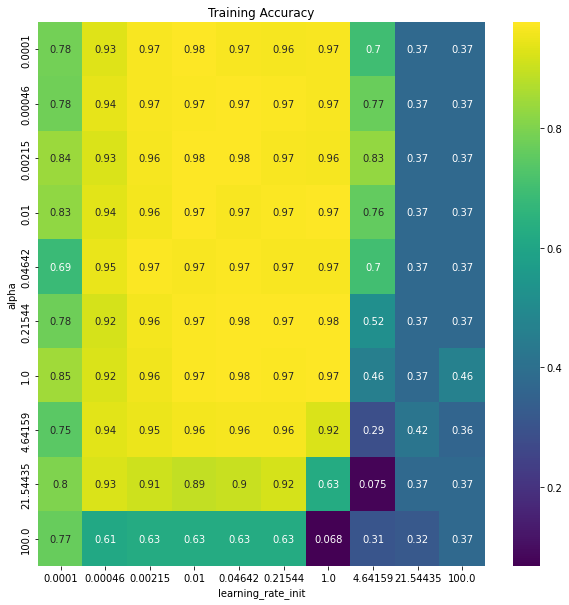

In [212]:
df_p = data.pivot("alpha","learning_rate_init","mean_test_score")
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.heatmap(df_p, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")

#ax.set_ylabel("$\eta$")
#ax.set_xlabel("$\lambda$")
plt.show()

In [213]:
data.loc[data['rank_test_score'] == 1]

,alpha,learning_rate_init,mean_test_score,rank_test_score
3,0.0001,0.0100,0.9774,1
23,0.0022,0.0100,0.9774,1
64,1.0000,0.0464,0.9774,1


In [216]:
best_model.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__activation': 'relu',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 32,
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': (50,),
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.01,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 100,
 'estimator__momentum': 0.5,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__solver': 'sgd',
 'estimator__tol': 0,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': False,
 'estimator__warm_start': False,
 'estimator': MLPClassifier(batch_size=32, hidden_layer_sizes=(50,), learning_rate_init=0.01,
               max_iter=100, momentum=0.5, solver='sgd', tol=0),
 'n_jobs': -1,
 'param_grid': {'alpha': array([1.000000e-04,

In [446]:
from src.modelling.nn import NeuralNetwork
nn = NeuralNetwork(hidden_activation = 'relu',output_activation = 'sigmoid', loss_func = 'cross_entropy',
                   momentum = 0.5,w_init='glorot',batch_size = 32,n_epochs = 100,val_fraction=0.1)
nlambdas = 10
lambdas = np.round(np.logspace(-4, 1, nlambdas),4)
nlrs = 10
lrs = np.round(np.logspace(-4, 1, nlrs),4)

In [447]:
best_model, data = grid_search_df(X_train,z_train,nn, param_grid=dict(lmb=lambdas,lr0=lrs))

In [448]:
data

,lmb,lr0,mean_test_score,rank_test_score
0,0.0001,0.0001,0.8041,75
1,0.0001,0.0004,0.9272,66
2,0.0001,0.0013,0.9648,41
3,0.0001,0.0046,0.9698,27
4,0.0001,0.0167,0.9799,1
...,...,...,...,...
95,10.0000,0.0599,0.9573,52
96,10.0000,0.2154,0.9547,55
97,10.0000,0.7743,0.6690,85
98,10.0000,2.7826,0.6256,89


In [453]:
data.columns[0]

'lmb'

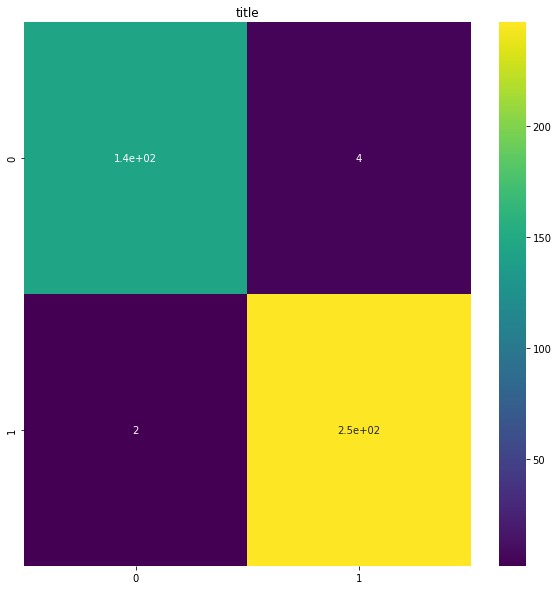

In [464]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(z_train,best_model.predict(X_train))
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.heatmap(conf_mat, annot=True, ax=ax, cmap="viridis")
ax.set_title('title')
plt.show()  

In [460]:
conf_mat

array([[145,   4],
       [  2, 247]], dtype=int64)

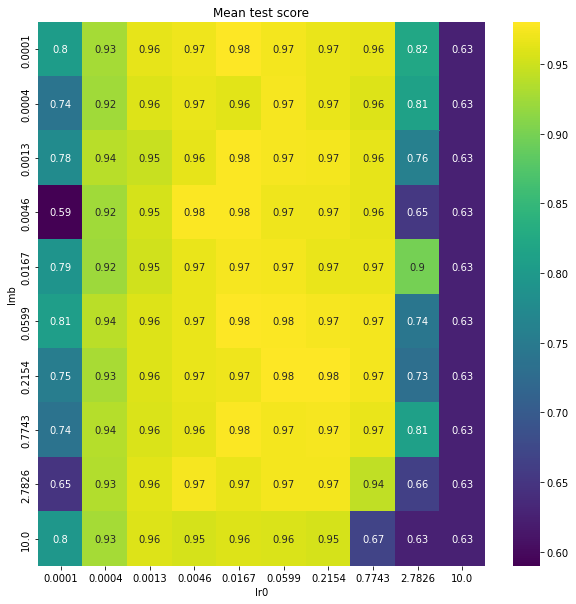

In [456]:
from src.visualization.visualize import *
plot_grid_search(data,('lmb','lr0'))

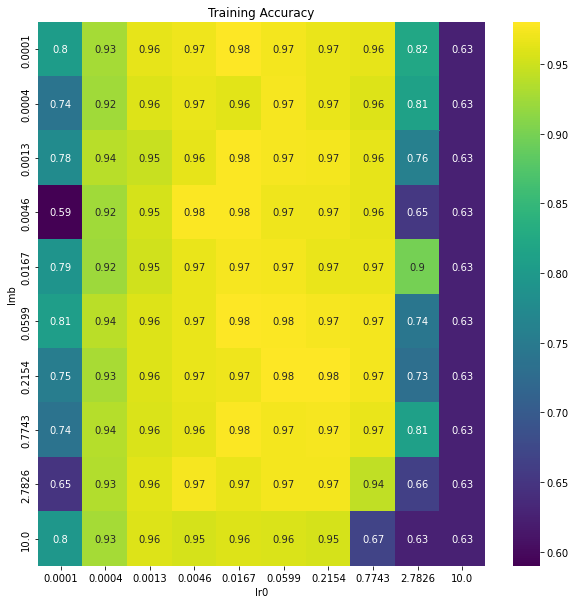

In [450]:
df_p = data.pivot("lmb","lr0","mean_test_score")
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.heatmap(df_p, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")

#ax.set_ylabel("$\eta$")
#ax.set_xlabel("$\lambda$")
plt.show()

In [358]:
from src.modelling.nn import NeuralNetwork
nn = NeuralNetwork(hidden_activation = 'relu',output_activation = 'sigmoid', loss_func = 'cross_entropy',
                   momentum = 0.5,w_init='glorot',batch_size = 32,n_epochs = 100,val_fraction=0.1,lr0=0.0001,lmb=0.01)
nn.fit(X_train,z_train)

In [359]:
nn.score(X_train,z_train)

0.9045226130653267

In [342]:
nn.set_params(lmb=15,lr0=10)

In [344]:
nn.lmb

15

In [345]:
nn.get_params()

{'regularization': 'l2',
 'lmb': 15,
 'momentum': 0.5,
 'schedule': 'constant',
 'lr0': 10,
 'batch_size': 32,
 'n_epochs': 100,
 't0': 50,
 'power_t': 0.05,
 'hidden_layer_sizes': (50,),
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid'}

In [347]:
nn.set_params(lmb=0)

In [371]:
nn.get_params()

{'regularization': 'l2',
 'lmb': 0.001,
 'momentum': 0.5,
 'schedule': 'constant',
 'lr0': 0.01,
 'batch_size': 32,
 'n_epochs': 100,
 't0': 50,
 'power_t': 0.05,
 'hidden_layer_sizes': (50,),
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid'}

In [417]:
nn.set_params(lmb=0.0001, lr0 = 0.0001)

In [418]:
nn.get_params()

{'regularization': 'l2',
 'lmb': 0.0001,
 'momentum': 0.5,
 'schedule': 'constant',
 'lr0': 0.0001,
 'batch_size': 32,
 'n_epochs': 100,
 't0': 50,
 'power_t': 0.05,
 'hidden_layer_sizes': (50,),
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid'}

In [419]:
nn.fit(X_train,z_train)

In [420]:
nn.score(X_train,z_train)

0.9020100502512562

In [423]:
nlambdas = 10
lambdas = np.logspace(-4, 1, nlambdas)
nlrs = 10
lrs = np.logspace(-4, 1, nlrs)
gridsearch = GridSearchCV(estimator=nn, param_grid=dict(lmb=lambdas,lr0=lrs),n_jobs=None,refit=True)
gridsearch.fit(X_train,z_train)

..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:1

..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:1

..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:209: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in add
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.wei

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
..\src\modelling\nn.py:164: RuntimeWarning: invalid value encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: invalid value encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: overflow enc

..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\_sgdBas

..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
..\src\modelling\nn.py:109:

..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: overflow encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:209: RuntimeWarning: invalid value encountered in multiply
  error = matmul(error, weights.T)*self.layers[0].derivative(self.layers[0].z_h,error)
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + 

..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: overflow encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
..\src\modelling\nn.py:239: Run

..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in matmul
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in matmul
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:181: RuntimeWarning: overflow encountered in matmul
  z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:235: RuntimeWarning: invalid value encountered in matmul
  w_grad = matmul(prev_layer_a.T,error)
..\src\modelling\nn.py:109: RuntimeWarning: overflow encountered in multiply
  loss += self.lmb * w @ w / (2*X.shape[0])
..\src\modelling\nn.py:164: RuntimeWarning: overflow encountered in add
  layer.z_h = matmul(a,layer.weights) + layer.bias
..\src\modelling\nn.py:239: RuntimeWarning: overflow encountered in multiply
  w_grad += self.lmb * current_layer_w


GridSearchCV(estimator=<src.modelling.nn.NeuralNetwork object at 0x000001DD2FF4F3D0>,
             param_grid={'lmb': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                         'lr0': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01])})

In [424]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lmb,param_lr0,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1829,0.0050,0.0000,0.0000,0.0001,0.0001,"{'lmb': 0.0001, 'lr0': 0.0001}",0.7625,0.6500,0.6250,0.6582,0.8861,0.7164,0.0970,86
1,0.1813,0.0025,0.0002,0.0004,0.0001,0.0004,"{'lmb': 0.0001, 'lr0': 0.00035938136638046257}",0.9500,0.9500,0.9250,0.9494,0.9620,0.9473,0.0121,59
2,0.1904,0.0048,0.0002,0.0004,0.0001,0.0013,"{'lmb': 0.0001, 'lr0': 0.001291549665014884}",0.9875,0.9500,0.9375,0.9494,0.9494,0.9547,0.0170,54
3,0.1895,0.0027,0.0004,0.0005,0.0001,0.0046,"{'lmb': 0.0001, 'lr0': 0.004641588833612782}",0.9875,0.9750,0.9500,0.9620,0.9494,0.9648,0.0147,41
4,0.1818,0.0070,0.0000,0.0000,0.0001,0.0167,"{'lmb': 0.0001, 'lr0': 0.016681005372000592}",0.9875,0.9750,0.9500,0.9620,0.9747,0.9698,0.0128,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.1654,0.0016,0.0000,0.0000,10.0000,0.0599,"{'lmb': 10.0, 'lr0': 0.05994842503189409}",0.9750,0.9625,0.9125,0.9747,0.9494,0.9548,0.0232,51
96,0.1642,0.0012,0.0000,0.0000,10.0000,0.2154,"{'lmb': 10.0, 'lr0': 0.21544346900318845}",0.9875,0.9625,0.9375,0.9747,0.9367,0.9598,0.0201,47
97,0.1644,0.0015,0.0000,0.0000,10.0000,0.7743,"{'lmb': 10.0, 'lr0': 0.7742636826811278}",0.8625,0.3500,0.8625,0.9494,0.8608,0.7770,0.2162,80
98,0.1699,0.0030,0.0000,0.0000,10.0000,2.7826,"{'lmb': 10.0, 'lr0': 2.782559402207126}",0.6125,0.6500,0.6375,0.5190,0.7089,0.6256,0.0620,89
